<a href="https://colab.research.google.com/github/DanBaissa/symbolic_regression_polisci/blob/main/symbolic_regression_polisci_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression in Political Science: Classic and Game Theory Models

by Daniel K Baissa
---

## Overview

This educational notebook demonstrates how **symbolic regression**—a machine learning technique that automatically discovers mathematical equations—can help political scientists and social scientists uncover the underlying functional relationships in data. Instead of pre-selecting a model form (like linear or quadratic), symbolic regression explores a huge space of possible equations and finds the one(s) that best fit the observed data. This makes it especially useful for:

- Detecting non-linearities, thresholds, and cycles that traditional regressions may miss.
- Revealing interaction effects, periodicities, and coordination dynamics.
- Providing **interpretable formulas** instead of black-box predictions.

The notebook combines classic social science and political economy data-generating processes (linear, quadratic, interaction, cyclical) **with three fundamental game theory models**: the Prisoner's Dilemma, Hawk-Dove, and Stag Hunt. Each is explained, simulated with noise (to mimic real-world data), and fit using two symbolic regression engines:

- Python’s `gplearn` (genetic programming)
- Julia’s `PySR` (highly efficient, often simpler equations)

For each dataset, you’ll see:

- The context and political science analogy
- The discovered formula (compared to the “ground truth”)
- The test-set fit (R²)
- Example paper-style writeups for interpreting your findings

You can easily adapt this notebook to your own data by replacing the simulated examples with your real political science or social science dataset. Symbolic regression can help you:

- Check if theory-driven models match empirical patterns
- Discover new hypotheses or nonlinearities you might otherwise miss
- Communicate complex patterns in a single, readable formula

This notebook is organized for education and exploration, with clear markdown explanations, analogies, and visualizations for each step. See the sections below for details on data generation, model fitting, results, and interpretation.

---

## 2. Installation and Imports

We need some specialized libraries for this demonstration:

- `gplearn`: Python package for symbolic regression using genetic programming.
- `pysr`: Python package that runs symbolic regression using Julia in the backend, often producing simpler equations.
- Standard libraries: Numpy (math), Matplotlib (plotting), Pandas (tables), Scikit-learn (splitting data and metrics).

*This cell installs and imports everything you need to run the notebook.*

In [1]:
!pip install gplearn pysr julia
import julia
julia.install()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.0 MB/s eta 0:00:00



Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.


## 3. Data Generation: Classic Relationships & Game Theory Models

We’ll use **seven datasets** in total:

- Four "classic" social science models, representing different types of hypothesized causal relationships (linear, quadratic, interaction, sinusoidal).
- Three game theory models: **Prisoner’s Dilemma**, **Hawk-Dove**, and **Stag Hunt**. These represent some of the most influential mathematical frameworks for thinking about political strategy and cooperation/conflict.

A small amount of noise is added to each, mimicking the uncertainty present in real-world social science data.

Each dataset will have its own *explanation* before you see results.

In [2]:
rng = np.random.default_rng(42)
X = np.linspace(-3, 3, 200).reshape(-1, 1)

# Classic models
y_linear = 2.5 * X.ravel() + 3 + rng.normal(0, 0.1, X.shape[0])  # Linear effect
y_quadratic = -1.2 * (X.ravel() ** 2) + 2 * X.ravel() + 1 + rng.normal(0, 0.1, X.shape[0])  # Inverted U-shape
X2 = rng.uniform(-3, 3, X.shape[0])  # For interaction term
y_interaction = 1.5 * X.ravel() * X2 + 0.5 * X2 + rng.normal(0, 0.1, X.shape[0])
y_sinusoidal = 1.8 * np.sin(1.5 * X.ravel()) + 0.2 * X.ravel() + rng.normal(0, 0.1, X.shape[0])

# Game theory: Prisoner's Dilemma
n_game = 300
A1 = rng.integers(0, 2, n_game)
A2 = rng.integers(0, 2, n_game)
T, R, P, S = 5, 3, 1, 0
payoff_pd = np.where((A1 == 0) & (A2 == 0), R,
              np.where((A1 == 0) & (A2 == 1), S,
              np.where((A1 == 1) & (A2 == 0), T, P))) \
              + rng.normal(0, 0.05, n_game)

# Hawk-Dove
H1 = rng.integers(0, 2, n_game)
H2 = rng.integers(0, 2, n_game)
V, C = 4, 6
payoff_hd = np.where((H1 == 1) & (H2 == 1), (V-C)/2,
              np.where((H1 == 1) & (H2 == 0), V,
              np.where((H1 == 0) & (H2 == 1), 0, V/2))) \
              + rng.normal(0, 0.05, n_game)

# Stag Hunt
S1 = rng.integers(0, 2, n_game)
S2 = rng.integers(0, 2, n_game)
payoff_sh = np.where((S1 == 1) & (S2 == 1), 4,
              np.where((S1 == 0) & (S2 == 0), 2,
              np.where((S1 == 1) & (S2 == 0), 0, 2))) \
              + rng.normal(0, 0.05, n_game)

datasets = [
    ("Linear", X, y_linear, None),
    ("Quadratic", X, y_quadratic, None),
    ("Interaction", np.column_stack([X.ravel(), X2]), y_interaction, X2),
    ("Sinusoidal", X, y_sinusoidal, None),
    ("Prisoners Dilemma", np.column_stack([A1, A2]), payoff_pd, None),
    ("Hawk-Dove", np.column_stack([H1, H2]), payoff_hd, None),
    ("Stag Hunt", np.column_stack([S1, S2]), payoff_sh, None)
]

## 4. Symbolic Regression with Python (`gplearn`): All Datasets

We use the Python-based `gplearn` library to try to recover the data-generating equation from each dataset.  
For each dataset:

- We split into train/test sets.
- Fit the symbolic regressor (using genetic programming).
- Print the discovered equation and its $R^2$ on the held-out test set.
- Show a plot of predictions vs. true outcomes.

### **What is gplearn doing?**
`gplearn` starts with random equations, evaluates their fit, and iteratively evolves them (by "breeding" and "mutating" equations), mimicking evolution.  
The best formula it finds is human-readable, making it easy to check whether the algorithm “discovered” the truth.

**Scroll down to see the explanations for each dataset as the results appear.**


=== Linear (Python/gplearn) ===
Linear: Classic single-cause relationship. E.g., each unit increase in income leads to a fixed change in outcome.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): mul(add(0.991, add(X0, 0.194)), div(0.991, 0.394))
Test set R^2: 1.000


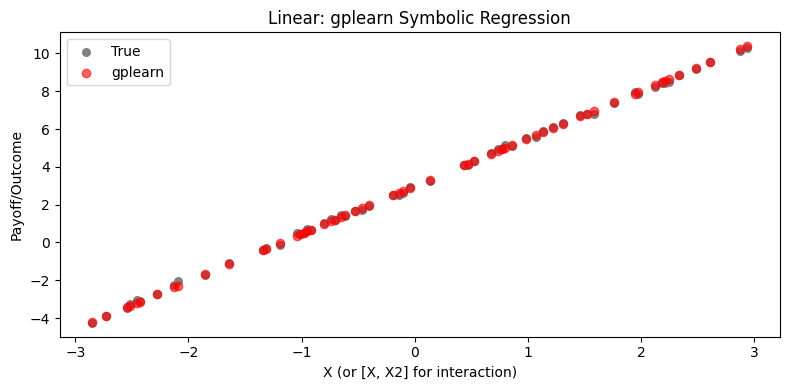


=== Quadratic (Python/gplearn) ===
Quadratic: Represents an inverted-U or U-shaped relationship, e.g. moderate levels of democracy promote growth but too much or too little may be harmful.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): sub(add(sub(0.817, X0), add(X0, 0.138)), add(add(mul(X0, X0), mul(-0.693, X0)), add(mul(-0.963, X0), mul(-0.223, add(sub(X0, mul(add(0.388, X0), X0)), sub(X0, -0.428))))))
Test set R^2: 0.999


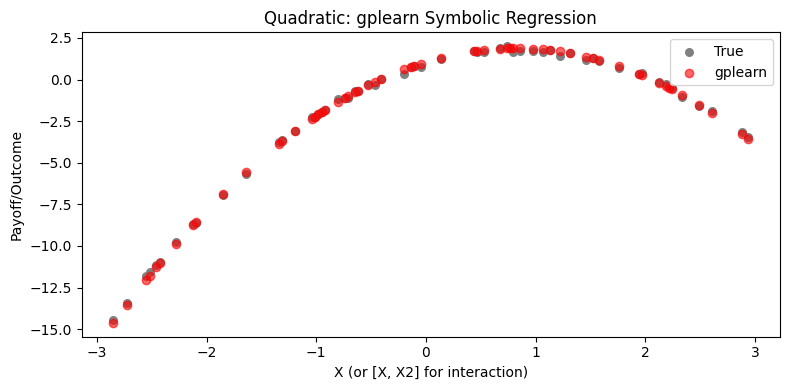


=== Interaction (Python/gplearn) ===
Interaction: Outcome depends on two factors combined (e.g., aid effectiveness depends on both aid and governance quality).


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): mul(add(0.633, sub(add(X0, X0), mul(0.662, mul(0.662, X0)))), X1)
Test set R^2: 0.995


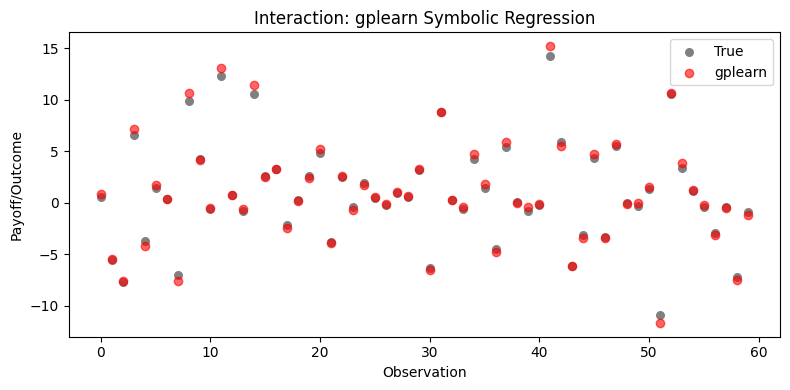


=== Sinusoidal (Python/gplearn) ===
Sinusoidal: Cyclical relationship (e.g., protest or violence waves, seasonal effects).


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): div(div(add(X0, X0), X0), sub(X0, div(-0.487, X0)))
Test set R^2: 0.691


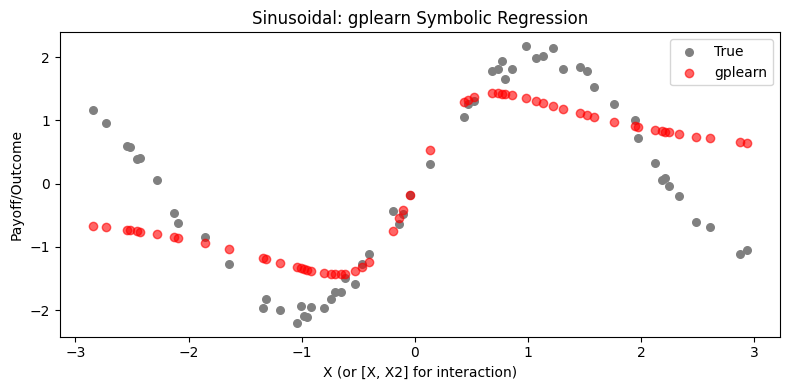


=== Prisoners Dilemma (Python/gplearn) ===
Prisoner's Dilemma: Classic two-player game; payoff depends on both players' strategies.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): add(add(div(0.139, X1), div(X0, X1)), sub(add(mul(div(X0, -0.481), sub(X1, 0.978)), 0.936), X1))
Test set R^2: 0.999


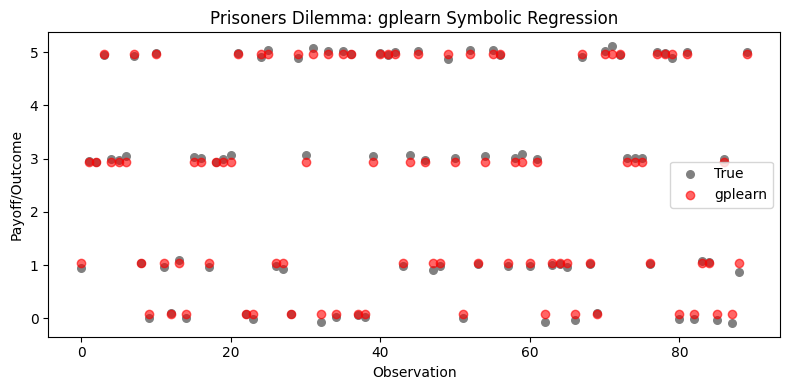


=== Hawk-Dove (Python/gplearn) ===
Hawk-Dove: Models conflict escalation and compromise, payoffs depend on whether you escalate or yield.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): sub(add(mul(div(X0, -0.481), sub(X1, X0)), div(X0, X0)), add(add(-0.771, X0), add(add(X1, X1), sub(mul(X0, X1), add(0.176, X0)))))
Test set R^2: 0.999


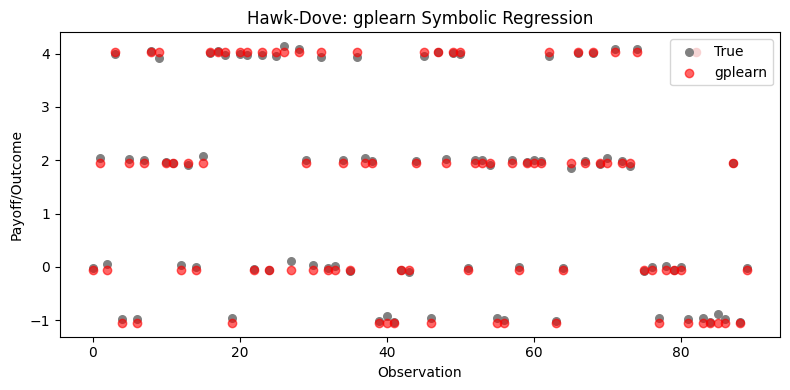


=== Stag Hunt (Python/gplearn) ===
Stag Hunt: Models coordination/trust. Payoff is highest if both cooperate on 'Stag', but safe/mediocre if both play 'Hare'.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): add(mul(add(X1, X1), X0), add(div(X1, X0), div(X1, X0)))
Test set R^2: 0.999


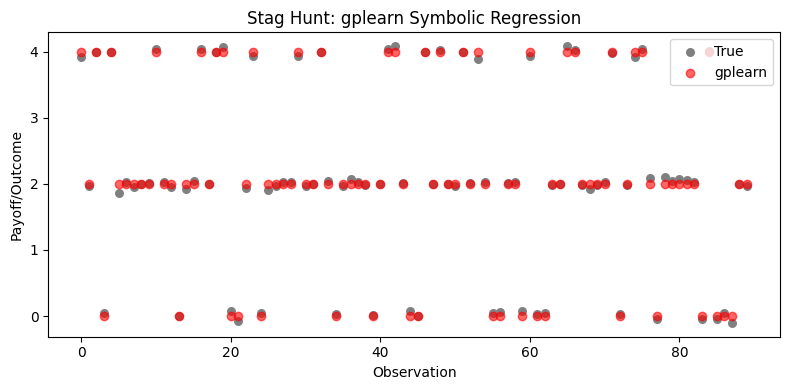

In [3]:
from gplearn.genetic import SymbolicRegressor

gplearn_results = []

for name, X_data, y_data, _ in datasets:
    print(f"\n=== {name} (Python/gplearn) ===")

    # Explanatory text for each model
    if name == "Linear":
        print("Linear: Classic single-cause relationship. E.g., each unit increase in income leads to a fixed change in outcome.")
    elif name == "Quadratic":
        print("Quadratic: Represents an inverted-U or U-shaped relationship, e.g. moderate levels of democracy promote growth but too much or too little may be harmful.")
    elif name == "Interaction":
        print("Interaction: Outcome depends on two factors combined (e.g., aid effectiveness depends on both aid and governance quality).")
    elif name == "Sinusoidal":
        print("Sinusoidal: Cyclical relationship (e.g., protest or violence waves, seasonal effects).")
    elif name == "Prisoners Dilemma":
        print("Prisoner's Dilemma: Classic two-player game; payoff depends on both players' strategies.")
    elif name == "Hawk-Dove":
        print("Hawk-Dove: Models conflict escalation and compromise, payoffs depend on whether you escalate or yield.")
    elif name == "Stag Hunt":
        print("Stag Hunt: Models coordination/trust. Payoff is highest if both cooperate on 'Stag', but safe/mediocre if both play 'Hare'.")

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.3, random_state=42)

    py_est = SymbolicRegressor(
        population_size=1000, generations=20, stopping_criteria=0.01,
        p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.05,
        p_point_mutation=0.1, max_samples=0.9, verbose=0,
        parsimony_coefficient=0.01, random_state=0
    )
    py_est.fit(X_train, y_train)
    y_pred_py = py_est.predict(X_test)
    py_r2 = r2_score(y_test, y_pred_py)
    py_eq = str(py_est._program)
    print(f"Discovered equation (Python): {py_eq}")
    print(f"Test set R^2: {py_r2:.3f}")

    gplearn_results.append({
        'name': name,
        'eq': py_eq,
        'r2': py_r2,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred_py
    })

    # Plot
    plt.figure(figsize=(8,4))
    if X_test.ndim == 1 or X_test.shape[1] == 1:
        plt.scatter(X_test, y_test, color='gray', label='True', s=30)
        plt.scatter(X_test, y_pred_py, color='red', label='gplearn', alpha=0.6)
        plt.xlabel("X (or [X, X2] for interaction)")
    else:
        plt.scatter(np.arange(len(y_test)), y_test, color='gray', label='True', s=30)
        plt.scatter(np.arange(len(y_test)), y_pred_py, color='red', label='gplearn', alpha=0.6)
        plt.xlabel("Observation")
    plt.title(f"{name}: gplearn Symbolic Regression")
    plt.ylabel("Payoff/Outcome")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 5. Symbolic Regression with Julia (`PySR`): All Datasets

Now we use the Julia-based `PySR` package, which is often even better at finding compact, human-readable equations.  
Everything else is the same as above—this time, look for differences in the equations produced!

### **What is PySR doing?**
PySR also uses evolutionary algorithms (and some other tricks), but is usually faster and can handle more complex algebra.  
It runs Julia in the backend, but you never have to leave Python.

**Scroll down to see if PySR does better, worse, or just different!**

[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.9 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Writing Project.toml:
             [deps]
             SymbolicRegression = "8254be44-1295-4e6a-a16d-46603ac705cb"
             Serialization = "9e88b42a-f829-5b0c-bbe9-9e923198166b"
             PythonCall = "6099a3de-0909-46bc-b1f4-468b9a2dfc0d"
             OpenSSL_jll = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
             [compat]
             SymbolicRegression = "~1.11"
             Serialization = "^1"
             PythonCall = "=0.9.25"
             OpenSSL_jll = "~3.0"
[juliapkg] Installing packages:
             import Pkg
    

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): pick         score                                           equation  \
Test set R^2: 1.000


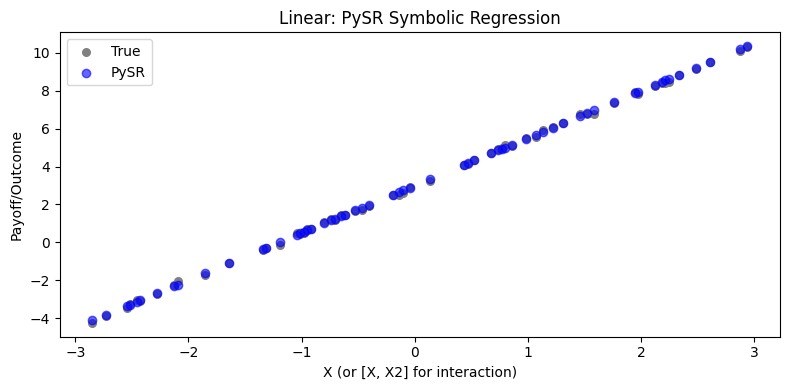


=== Quadratic (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): pick         score                                           equation  \
Test set R^2: 0.999


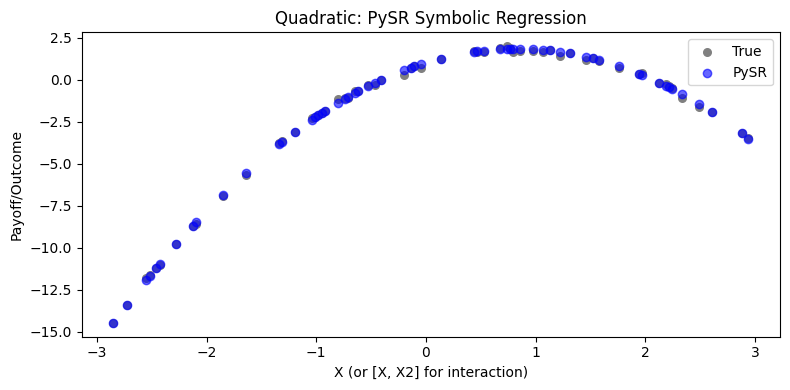


=== Interaction (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): pick     score                                           equation  \
Test set R^2: 1.000


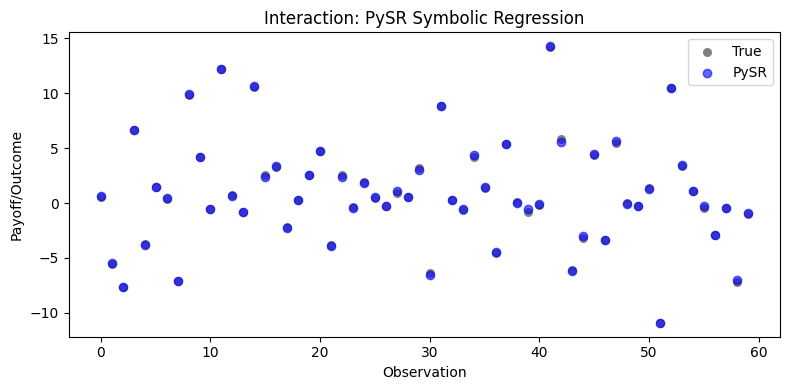


=== Sinusoidal (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): pick     score                                           equation  \
Test set R^2: 0.988


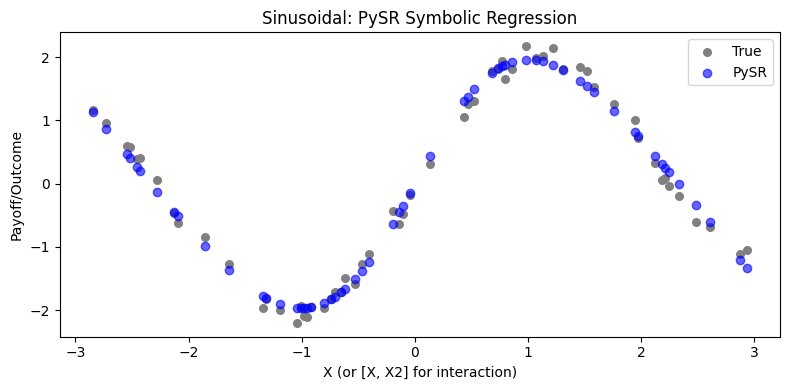


=== Prisoners Dilemma (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): pick     score                                           equation  \
Test set R^2: 0.999


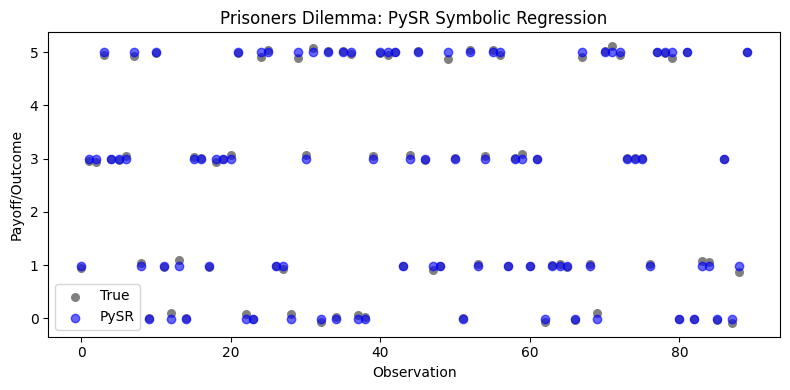


=== Hawk-Dove (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): pick     score                                           equation  \
Test set R^2: 0.999


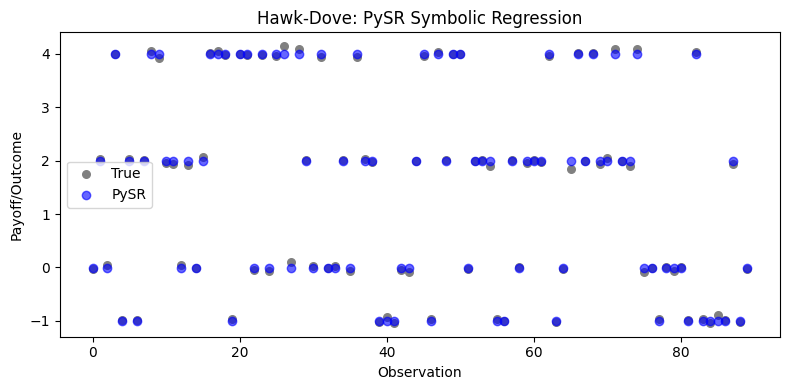

In [ ]:
from pysr import PySRRegressor

pysr_results = []

for name, X_data, y_data, _ in datasets:
    print(f"\n=== {name} (Julia/PySR) ===")
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.3, random_state=42)

    pysr_est = PySRRegressor(
        niterations=30, population_size=500, model_selection="best",
        maxsize=15, verbosity=0,
    )
    pysr_est.fit(X_train, y_train)
    y_pred_jl = pysr_est.predict(X_test)
    jl_r2 = r2_score(y_test, y_pred_jl)
    jl_eq = str(pysr_est)
    # Print the top equation PySR found (usually the first non-header line)
    top_eq = jl_eq.split('\n')[1].strip() if len(jl_eq.split('\n')) > 1 else jl_eq
    print(f"Discovered equation (Julia): {top_eq}")
    print(f"Test set R^2: {jl_r2:.3f}")

    pysr_results.append({
        'name': name,
        'eq': top_eq[:60] + "...",
        'r2': jl_r2,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred_jl
    })

    # Plot
    plt.figure(figsize=(8,4))
    if X_test.ndim == 1 or X_test.shape[1] == 1:
        plt.scatter(X_test, y_test, color='gray', label='True', s=30)
        plt.scatter(X_test, y_pred_jl, color='blue', label='PySR', alpha=0.6)
        plt.xlabel("X (or [X, X2] for interaction)")
    else:
        plt.scatter(np.arange(len(y_test)), y_test, color='gray', label='True', s=30)
        plt.scatter(np.arange(len(y_test)), y_pred_jl, color='blue', label='PySR', alpha=0.6)
        plt.xlabel("Observation")
    plt.title(f"{name}: PySR Symbolic Regression")
    plt.ylabel("Payoff/Outcome")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 6. Comparing Results: Table of Equations and Performance

Below you’ll find a summary table showing:

- The equation discovered by each regressor for each dataset
- Out-of-sample $R^2$ performance

**Questions for reflection:**

- Which relationships were easiest or hardest to recover?
- Do the equations match your expectations?
- Are the results interpretable, and how would you report them in a paper?

In [ ]:
summary = []
for g, j in zip(gplearn_results, pysr_results):
    summary.append({
        'Relationship': g['name'],
        'Python Equation': g['eq'],
        'Python R²': f"{g['r2']:.3f}",
        'Julia Equation': j['eq'],
        'Julia R²': f"{j['r2']:.3f}",
    })
df_summary = pd.DataFrame(summary)
df_summary